# Data Preparation

TODO: HANDLE ZEROED VALUES

* In our test.csv we have to predict 8 months in the future
* Kaggle will release a new test.csv with future months: March, April, May 2023
* So we need to predict 3 months in the future for the main test
* But we need to predict 8 months in the current test.csv
* We could model our nn to predict the next 3 months and then merge the predictions to get 8 months
* Parameters:
    * We should test using a different number of lag features in the model and comparing the results
    * We should be able to also choose the number of months to predict

In [1]:
import pandas as pd
import numpy as np
import math

df_train = pd.read_csv('io/dataset/train.csv')
df_coords = pd.read_csv('io/customdata/cfips_coordinates.csv')

df_train.sort_values(by=['cfips', 'first_day_of_month'], inplace=True)
df_train.reset_index(drop=True, inplace=True)

In [2]:
# There are some 0 values inside microbusiness_density and active columns
df_train.eq(0).any()

row_id                   False
cfips                    False
county                   False
state                    False
first_day_of_month       False
microbusiness_density     True
active                    True
dtype: bool

In [3]:
df_train.loc[0]['microbusiness_density']

3.0076818

In [4]:
# we don't use active column, so we can ignore it
_zeroeds = df_train.query('microbusiness_density == 0')['microbusiness_density'].count()
print(f"Number of 0 values in microbusiness_density column: {_zeroeds}")

Number of 0 values in microbusiness_density column: 26


In [5]:
# Customizable Parameters

NUMBER_OF_LAGS = 3
NUMBER_OF_PREDICTIONS = 3

In [6]:
def prepare_train_data(df_train, df_coords, n_lag=7, n_predict=3, drop_months_before_predict=1):
  df_copy = df_train.copy()[['cfips', 'first_day_of_month', 'microbusiness_density']]
  df_copy['first_day_of_month'] = pd.to_datetime(df_copy['first_day_of_month'], format='%Y-%m-%d')
  cfips = df_copy['cfips'].unique()
  #! TODO: I SHOULD HANDLE ZEROED VALUES DIFFERENTLY
  df_copy['microbusiness_density'] = df_copy['microbusiness_density'].replace(0, 0.0000010)
  # predict features
  for i in range(1+drop_months_before_predict, n_predict + 1+drop_months_before_predict):
    df_copy[f'predict_{i}'] = df_copy.groupby(['cfips'])['microbusiness_density'].shift(-i)
  # lag and diff features
  for i in range(1, n_lag + 1):
    df_copy[f'lag_{i}'] = df_copy.groupby(['cfips'])['microbusiness_density'].shift(i)
    if i == 1:
      df_copy[f'diff_{i}'] = df_copy['microbusiness_density'] - df_copy[f'lag_{i}']
      df_copy[f'diffdiv_{i}'] = df_copy[f'microbusiness_density'] / df_copy[f'lag_{i}'] - 1
    else:
      df_copy[f'diff_{i}'] = df_copy[f'lag_{i-1}'] - df_copy[f'lag_{i}']
      df_copy[f'diffdiv_{i}'] = df_copy[f'diff_{i}'] / df_copy[f'lag_{i}'] - 1
    df_copy[f'diff_{i}'] = df_copy[f'diff_{i}'].abs()
    df_copy[f'diffdiv_{i}'] = df_copy[f'diffdiv_{i}'].abs()
  # latitude and longitude
  for row in df_coords.itertuples():
    if row.cfips in cfips:
        df_copy.loc[df_copy['cfips'] == row.cfips, 'latitude'] = row.lat
        df_copy.loc[df_copy['cfips'] == row.cfips, 'longitude'] = row.lon
  df_copy['cfips'] = df_copy['cfips'].astype('float16')
  # transform first_day_of_month to year and month
  df_copy['year'] = df_copy['first_day_of_month'].dt.year.astype('float16')
  df_copy['month'] = df_copy['first_day_of_month'].dt.month.astype('float16')
  # dropna
  df_copy.dropna(inplace=True)
  df_copy.reset_index(drop=True, inplace=True)
  # split predict columns
  df_predict_columns = [col for col in df_copy if col.startswith('predict')]
  df_predict = df_copy[df_predict_columns]
  # drop columns
  df_drop_columns = [] + df_predict_columns
  df_copy.drop(df_drop_columns, axis=1, inplace=True)
  #! TODO: I SHOULD HANDLE ZEROED VALUES DIFFERENTLY
  for i in range(1, n_lag + 1):
    df_copy[f'lag_{i}'] = df_copy[f'lag_{i}'].replace(0, 0.0000010)
    df_copy[f'diff_{i}'] = df_copy[f'diff_{i}'].replace(0, 0.0000010)
    df_copy[f'diffdiv_{i}'] = df_copy[f'diffdiv_{i}'].replace(0, 0.0000010)
  # convert to float
  #df_copy = df_copy.astype('float16')
  # return X and y
  return df_copy, df_predict

In [7]:
df_prepared, df_prepared_predict = prepare_train_data(
  df_train,
  df_coords,
  n_lag=NUMBER_OF_LAGS,
  n_predict=NUMBER_OF_PREDICTIONS,
)

In [8]:
_zeroeds = df_prepared.eq(0).any().sum()
print(f"Number of 0 values in dataset: {_zeroeds}")

df_prepared.eq(0).any()

Number of 0 values in dataset: 0


cfips                    False
first_day_of_month       False
microbusiness_density    False
lag_1                    False
diff_1                   False
diffdiv_1                False
lag_2                    False
diff_2                   False
diffdiv_2                False
lag_3                    False
diff_3                   False
diffdiv_3                False
latitude                 False
longitude                False
year                     False
month                    False
dtype: bool

In [9]:
# list features
# The first item should look like this:
#           mbd       lag_1     diff_1   lag_2    diff_2    lag_3    diff_3
#           2,993233  3,055843 -0,06261 2,88487 0,170973 3,007682 -0,122812
df_prepared.tail()

,cfips,first_day_of_month,microbusiness_density,lag_1,diff_1,diffdiv_1,lag_2,diff_2,diffdiv_2,lag_3,diff_3,diffdiv_3,latitude,longitude,year,month
100315,56032.0,2022-02-01,1.749688,1.749688,0.000001,0.000001,1.796300,0.046612,1.025949,1.760374,0.035926,0.979592,43.77916,-104.235812,2022.0,2.0
100316,56032.0,2022-03-01,1.767542,1.749688,0.017854,0.010204,1.749688,0.000001,1.000000,1.796300,0.046612,1.025949,43.77916,-104.235812,2022.0,3.0
100317,56032.0,2022-04-01,1.767542,1.767542,0.000001,0.000001,1.749688,0.017854,0.989796,1.749688,0.000001,1.000000,43.77916,-104.235812,2022.0,4.0
100318,56032.0,2022-05-01,1.803249,1.767542,0.035708,0.020202,1.767542,0.000001,1.000000,1.749688,0.017854,0.989796,43.77916,-104.235812,2022.0,5.0
100319,56032.0,2022-06-01,1.803249,1.803249,0.000001,0.000001,1.767542,0.035708,0.979798,1.767542,0.000001,1.000000,43.77916,-104.235812,2022.0,6.0


In [10]:
df_prepared_predict.tail()

,predict_2,predict_3,predict_4
100315,1.767542,1.803249,1.803249
100316,1.803249,1.803249,1.803249
100317,1.803249,1.803249,1.785395
100318,1.803249,1.785395,1.785395
100319,1.785395,1.785395,1.785395


<AxesSubplot: xlabel='first_day_of_month'>

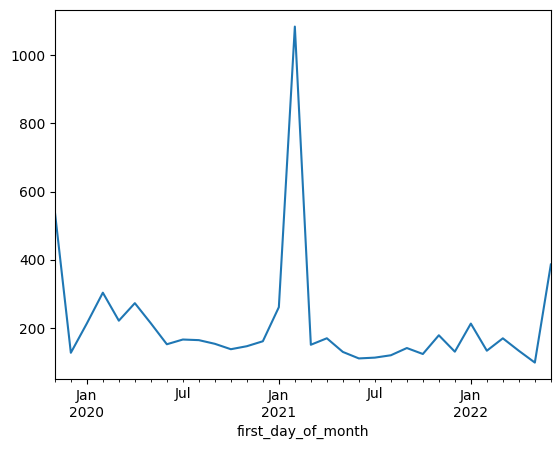

In [11]:
# TEST
df_prepared.groupby('first_day_of_month')['diff_1'].sum().plot()

<AxesSubplot: xlabel='first_day_of_month'>

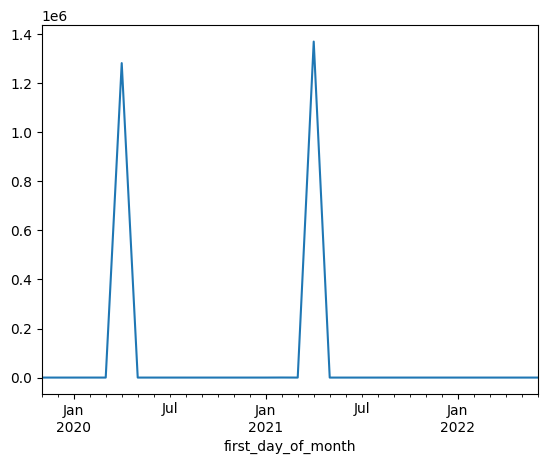

In [12]:
# TEST
df_prepared.groupby('first_day_of_month')['diffdiv_1'].sum().plot()

<AxesSubplot: xlabel='first_day_of_month'>

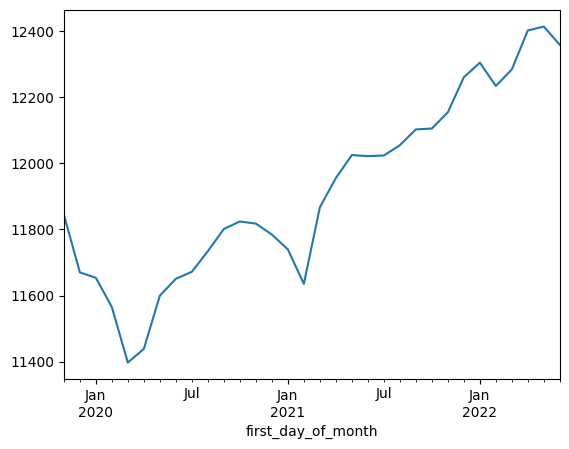

In [13]:
# TEST
df_prepared.groupby('first_day_of_month')['lag_1'].sum().plot()

In [14]:
df_prepared.columns

Index(['cfips', 'first_day_of_month', 'microbusiness_density', 'lag_1',
       'diff_1', 'diffdiv_1', 'lag_2', 'diff_2', 'diffdiv_2', 'lag_3',
       'diff_3', 'diffdiv_3', 'latitude', 'longitude', 'year', 'month'],
      dtype='object')

In [15]:
import torch
# [torch.tensor(row.cfips, dtype=torch.float16) for row in df_prepared.itertuples()]

def to_tensor(df, target):
    cfips = torch.tensor(df['cfips'].values.astype(np.float32), dtype=torch.float32)
    year = torch.tensor(df['year'].values.astype(np.float32), dtype=torch.float32)
    month = torch.tensor(df['month'].values.astype(np.float32), dtype=torch.float32)
    latitude = torch.tensor(df['latitude'].values.astype(np.float32), dtype=torch.float32)
    longitude = torch.tensor(df['longitude'].values.astype(np.float32), dtype=torch.float32)
    mbd = torch.tensor(df['microbusiness_density'].values.astype(np.float32), dtype=torch.float32)
    for i in range(1, NUMBER_OF_LAGS + 1):
        lag = torch.tensor(df[f'lag_{i}'].values.astype(np.float32), dtype=torch.float32)
        diff = torch.tensor(df[f'diff_{i}'].values.astype(np.float32), dtype=torch.float32)
        diffdiv = torch.tensor(df[f'diffdiv_{i}'].values.astype(np.float32), dtype=torch.float32)
    targettensor = torch.tensor(target.values, dtype=torch.float32)
    outputtensor = torch.stack([cfips, year, month, latitude, longitude, mbd, lag, diff, diffdiv], dim=1).to(torch.float32)
    return outputtensor, targettensor

tensor_x, tensor_y = to_tensor(df_prepared.drop('first_day_of_month', axis=1), df_prepared_predict)
tensor_x = tensor_x.unsqueeze(0)
tensor_y = tensor_y.unsqueeze(0)

In [16]:
tensor_x.shape, tensor_y.shape

(torch.Size([1, 100320, 9]), torch.Size([1, 100320, 3]))

In [17]:
# https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

import torch

input_size = tensor_x.shape[2]
hidden_size = NUMBER_OF_PREDICTIONS
output_size = NUMBER_OF_PREDICTIONS
num_layers = 1
batch_first = True
batch_size = tensor_x.shape[0]

learning_rate = 0.001
epochs = 100

class GRUModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_first=True):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.gru = torch.nn.GRU(input_size, hidden_size, num_layers, batch_first=batch_first, bias=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hn=None):
        if hn is None:
            hn = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float32)
        out, _ = self.gru(x, hn)
        out = self.fc(out)
        return out, hn

# rnn = torch.nn.GRU(input_size, hidden_size, num_layers, batch_first=batch_first)
# hn = torch.zeros(num_layers, batch_size, hidden_size, dtype=torch.float32)
rnn = GRUModel(input_size, hidden_size, num_layers, batch_first=batch_first)

# todo train_loader
train_loader = [(tensor_x, tensor_y)]

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

hn = torch.zeros(num_layers, batch_size, hidden_size, dtype=torch.float32)

for epoch in range(epochs):
    rnn.train()
    for input_seq, target_seq in train_loader:
        optimizer.zero_grad()
        output, hn = rnn(input_seq, hn)
        # loss = criterion(output.squeeze(), target_seq)
        loss = criterion(output, target_seq)
        loss.backward()
        optimizer.step()
    print(f'epoch: {epoch}, loss: {loss.item()}')
    #for name, param in rnn.named_parameters():
    #    if param.grad is not None:
    #        print(name, param.grad.data.norm())

# save the trained model
torch.save(rnn, 'trained_model.pt')

#with torch.no_grad():
#    rnn.eval()
#    test_input = tensor_x
#    test_target = tensor_y
#    test_output, hn = rnn(test_input, hn)
#    print(test_output.squeeze())
#    print(test_target.squeeze())

shape hn torch.Size([1, 1, 3])
epoch: 0, loss: 42.85672378540039
shape hn torch.Size([1, 1, 3])
epoch: 1, loss: 42.831825256347656
shape hn torch.Size([1, 1, 3])
epoch: 2, loss: 42.80694580078125
shape hn torch.Size([1, 1, 3])
epoch: 3, loss: 42.78208541870117
shape hn torch.Size([1, 1, 3])
epoch: 4, loss: 42.75724411010742
shape hn torch.Size([1, 1, 3])
epoch: 5, loss: 42.732418060302734
shape hn torch.Size([1, 1, 3])
epoch: 6, loss: 42.707618713378906
shape hn torch.Size([1, 1, 3])
epoch: 7, loss: 42.68282699584961
shape hn torch.Size([1, 1, 3])
epoch: 8, loss: 42.65806579589844
shape hn torch.Size([1, 1, 3])
epoch: 9, loss: 42.63332748413086
shape hn torch.Size([1, 1, 3])
epoch: 10, loss: 42.60860061645508
shape hn torch.Size([1, 1, 3])
epoch: 11, loss: 42.58389663696289
shape hn torch.Size([1, 1, 3])
epoch: 12, loss: 42.5592155456543
shape hn torch.Size([1, 1, 3])
epoch: 13, loss: 42.5345573425293
shape hn torch.Size([1, 1, 3])
epoch: 14, loss: 42.509918212890625
shape hn torch.Siz